# NammaMetro Ridership EDA

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename, index_col=0)

#### Let's take a closer look at the daily ridership data that NammaMetro publishes

Source: [https://english.bmrc.co.in/ridership/](https://english.bmrc.co.in/ridership/)

The Namma Metro Ridership stats page publishes a breakdown of payment methods used daily by passengers entering the system.

![ridership_plot](nammametro_datapage.png)

### Earliest Record

In [58]:
df.head(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
0,26-10-2024,353460.0,352496.0,853.0,43.0,68.0,241883.0,7444.0,512.0,177279.0,49351.0,95571.0,32357.0


### Most Recent Record

In [59]:
df.tail(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
60,04-01-2025,439881.0,439037.0,724.0,67.0,53.0,108740.0,8928.0,443.0,212340.0,56517.0,116742.0,39081.0


#### Extend the table with two useful columns: `Day of Week` and `Total Riders`

In [60]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 'Tokens', 'Total NCMC', 'Group Ticket', 'Total QR']].sum(axis=1)
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

df[['Record Date', 'Day of Week', 'Total Riders']].tail()

,Record Date,Day of Week,Total Riders
56,2024-12-29,Sunday,600289.0
57,2024-12-31,Tuesday,755096.0
58,2025-01-02,Thursday,782248.0
59,2025-01-03,Friday,784453.0
60,2025-01-04,Saturday,770332.0


## Passenger Flow: First Glance

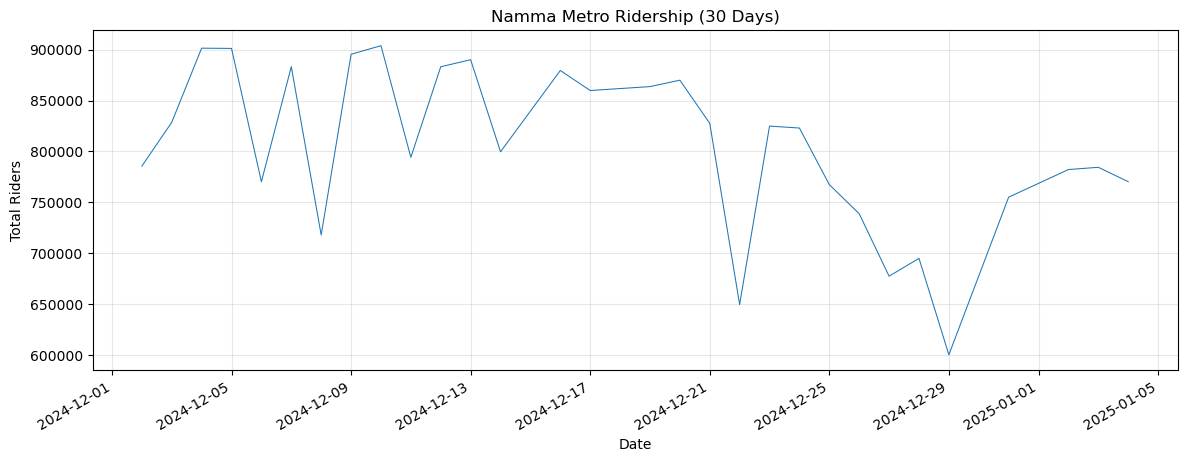

In [61]:
df.tail(30).plot(figsize=(14,5), 
                    kind='line', 
                    x='Record Date', 
                    xlabel='Date', 
                    y='Total Riders', 
                    ylabel='Total Riders', 
                    title='Namma Metro Ridership (30 Days)', 
                    legend=False,
                    linestyle='-',
                    linewidth=0.75)
plt.grid(True, alpha=0.3)
plt.show()

### Let's make a cleaner graph for the last N days of available data.

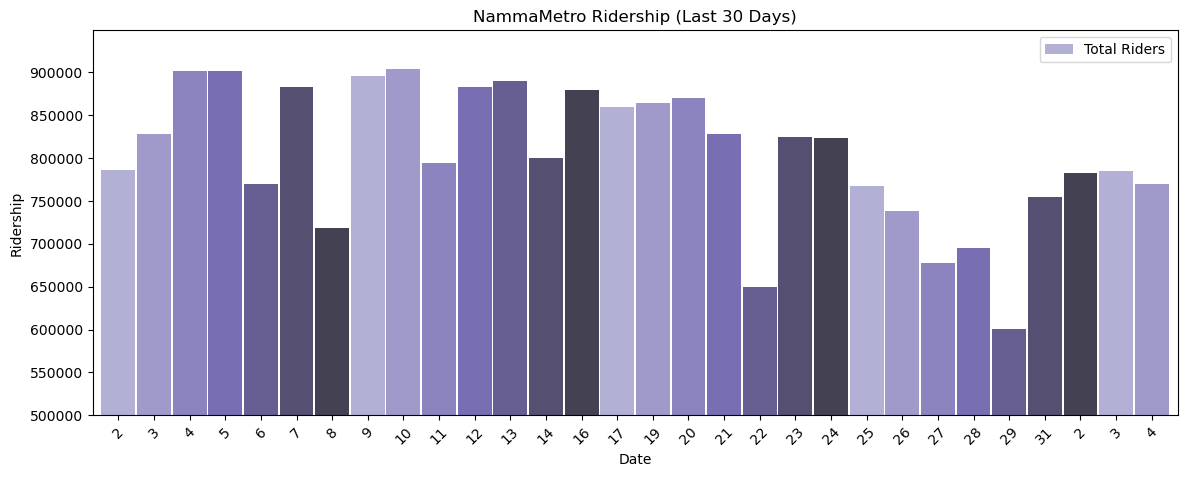

In [62]:
number_of_days = 30
Last_N_Days = df[['Record Date', 'Total Riders']].tail(number_of_days)
Last_N_Days['Record Date'] = pd.to_datetime(Last_N_Days['Record Date'], format='%d-%m-%Y').dt.day
Last_N_Days.plot(x='Record Date', 
                 y='Total Riders', 
                 kind='bar', 
                 xlabel='Date', 
                 ylabel='Ridership', 
                 title='NammaMetro Ridership (Last 30 Days)', 
                 figsize=(14,5), 
                 width=0.95,
                 legend=True,
                 color=sns.color_palette('Purples_d', 7),
                 rot=45)
plt.ylim(bottom=500000)
plt.show()

### Note the gaps in the data. 
NammaMetro fails to report ridership numbers on some days. Is someone updating the page manually?! 
Let's get a better understanding of that missing data.

In [63]:
from datetime import date, timedelta

start_date = date.today() - timedelta(number_of_days, 0, 0)
dates = pd.DataFrame({'Record Date': [str(start_date+timedelta(n)) for n in range(number_of_days)]})
dates['Record Date'] = pd.to_datetime(dates['Record Date'], format='%Y-%m-%d')

print(f"We will examine the data for an interval of the last {number_of_days} days, \
i.e. from {dates['Record Date'].min().strftime('%d-%m-%Y')} to {dates['Record Date'].max().strftime('%d-%m-%Y')}.")

We will examine the data for an interval of the last 30 days, i.e. from 06-12-2024 to 04-01-2025.


#### Missing Days

In [64]:
Last_N_Days = df.merge(dates, how='right', on='Record Date')
Last_N_Days.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
Last_N_Days.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

formatted_dates = pd.to_datetime(Last_N_Days['Record Date'], format='%Y-%m-%d').dt.strftime('%d')
formatted_numbers = Last_N_Days.loc[:, 'Smart Cards':'Total Riders'].astype('Int64')
formatted_dow = pd.to_datetime(Last_N_Days['Record Date'], format='%Y-%m-%d').dt.day_name()

Last_N_Days_1 = pd.concat([formatted_dates, formatted_numbers, formatted_dow], axis=1)
Last_N_Days_1[Last_N_Days_1['Smart Cards'].isnull()]

,Record Date,Smart Cards,Tokens,NCMC,Group Ticket,QR,Total Riders,Record Date
9,15,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Sunday
12,18,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Wednesday
24,30,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Monday
26,01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Wednesday


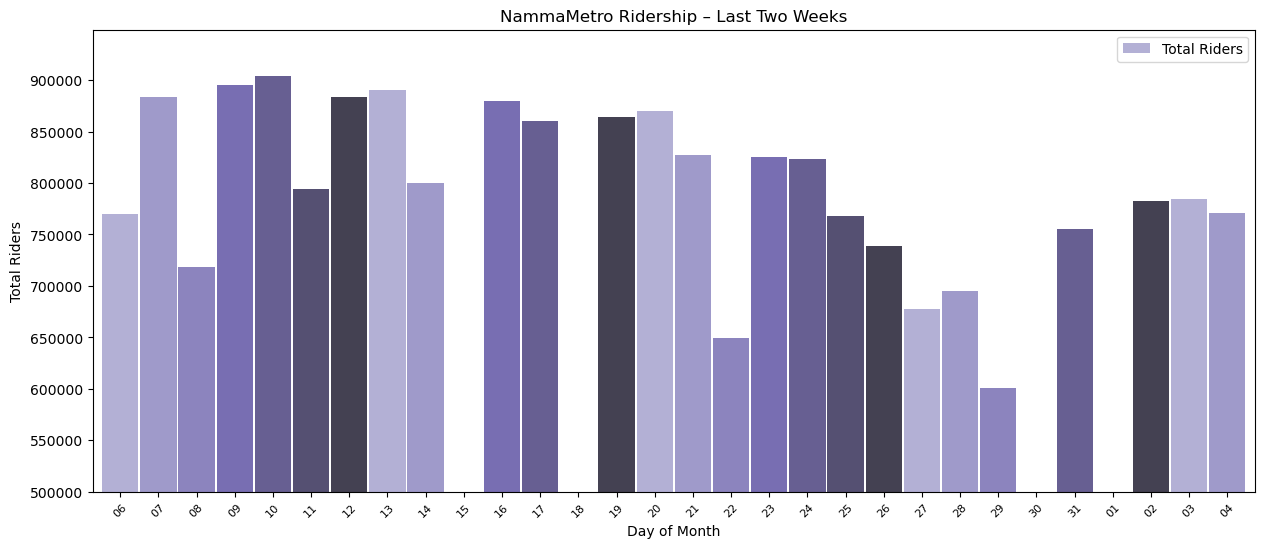

In [65]:
Last_N_Days_1.loc[:, :'Total Riders']\
           .plot(x='Record Date',
                 y='Total Riders',
                 kind='bar',
                 xlabel='Day of Month',
                 ylabel='Total Riders',
                 title='NammaMetro Ridership – Last Two Weeks', 
                 figsize=(15,6),
                 width=0.95,
                 color=sns.color_palette('Purples_d', 7),
                 legend=True,
                 rot=45)
plt.ylim(bottom=500000)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.show()

### Looks like a mouth with a few broken teeth!

What sort of data imputation makes sense here? 

When the dataset grows large enough over several months, it makes sense to fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4 available weekday Tuesdays.

## Smart Cards and Tokens are very popular with the public

#### Prepare the data to plot a bar chart stacked by access method

In [66]:
Last_N_Days_2 = Last_N_Days.melt(
                    id_vars=['Record Date'], 
                    value_vars=['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR'], 
                    var_name='Access Method', 
                    value_name='Count').sort_values(by=['Record Date', 'Access Method'])
Last_N_Days_2 = Last_N_Days_2[['Record Date', 'Access Method', 'Count']].sort_values(by=['Record Date', 'Access Method'], ignore_index=True)

formatted_dates = pd.to_datetime(Last_N_Days_2['Record Date'], format='%Y-%m-%d').dt.strftime('%d')
formatted_numbers = Last_N_Days_2.loc[:, 'Count'].astype('Int64')

Last_N_Days_2 = pd.concat([formatted_dates, Last_N_Days_2['Access Method'], formatted_numbers], axis=1)
Last_N_Days_2

,Record Date,Access Method,Count
0,06,Group Ticket,219
1,06,NCMC,12081
2,06,QR,117316
3,06,Smart Cards,415499
4,06,Tokens,225172
...,...,...,...
145,04,Group Ticket,443
146,04,NCMC,8928
147,04,QR,212340
148,04,Smart Cards,439881


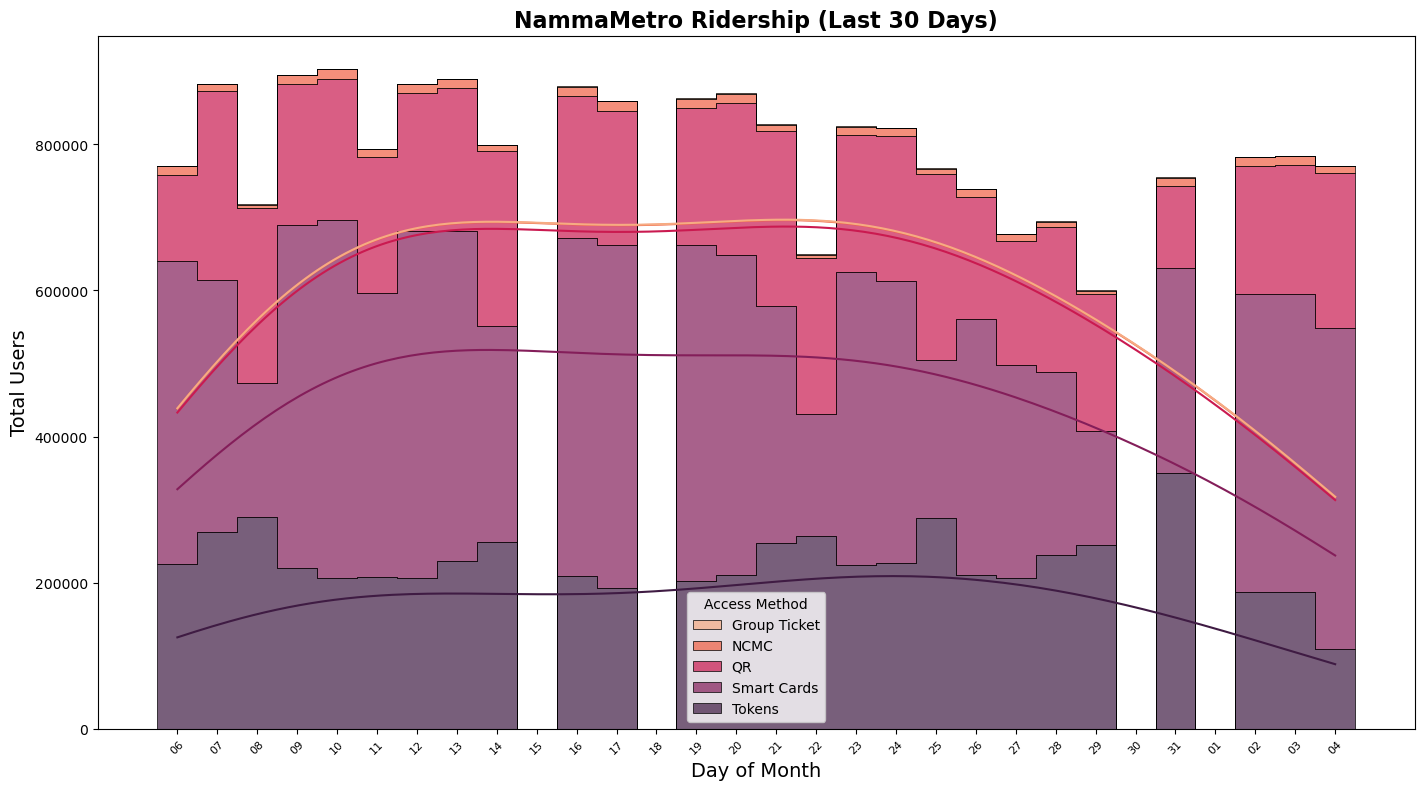

In [67]:
plt.figure(figsize=(17,9))
sns.histplot(data=Last_N_Days_2,    x='Record Date',
             weights='Count',       bins=number_of_days,
             hue='Access Method',   multiple='stack', 
             element='step',        palette='rocket_r',
             legend=True,           common_norm=True,
             stat='count',          linewidth=0.5,
             alpha=0.7,             discrete=True, 
             kde=True)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Total Users', fontsize=14)
plt.title(f'NammaMetro Ridership (Last {number_of_days} Days)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.show()

## NammaMetro on any given week

In [68]:
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

Day of Week
Sunday        8
Saturday     11
Friday        9
Thursday      8
Wednesday     7
Tuesday      10
Monday        8
Name: count, dtype: int64

In [69]:
weekly_average = df.merge(dates, how='right', on='Record Date')
weekly_average.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
weekly_average.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

weekly_average = weekly_average.groupby('Day of Week')[['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']].mean()
weekly_average = weekly_average.loc[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

for col in ['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']:
    weekly_average[col] = pd.to_numeric(weekly_average[col].fillna(0), errors='coerce').round().astype('Int64')

weekly_average = weekly_average[['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']]
weekly_average

,Smart Cards,Tokens,NCMC,Group Ticket,QR
Day of Week,,,,,
Sunday,169111,268276,4761,768,213032
Saturday,331634,224856,8509,737,229468
Friday,401024,211788,11510,482,173676
Thursday,423325,201630,12142,424,179493
Wednesday,302082,248216,8459,882,221190
Tuesday,407264,243424,12224,608,171966
Monday,444977,217546,12392,473,191261


### Surprise! While Smart Card usage peaks during the week, Token usage peaks on weekends.

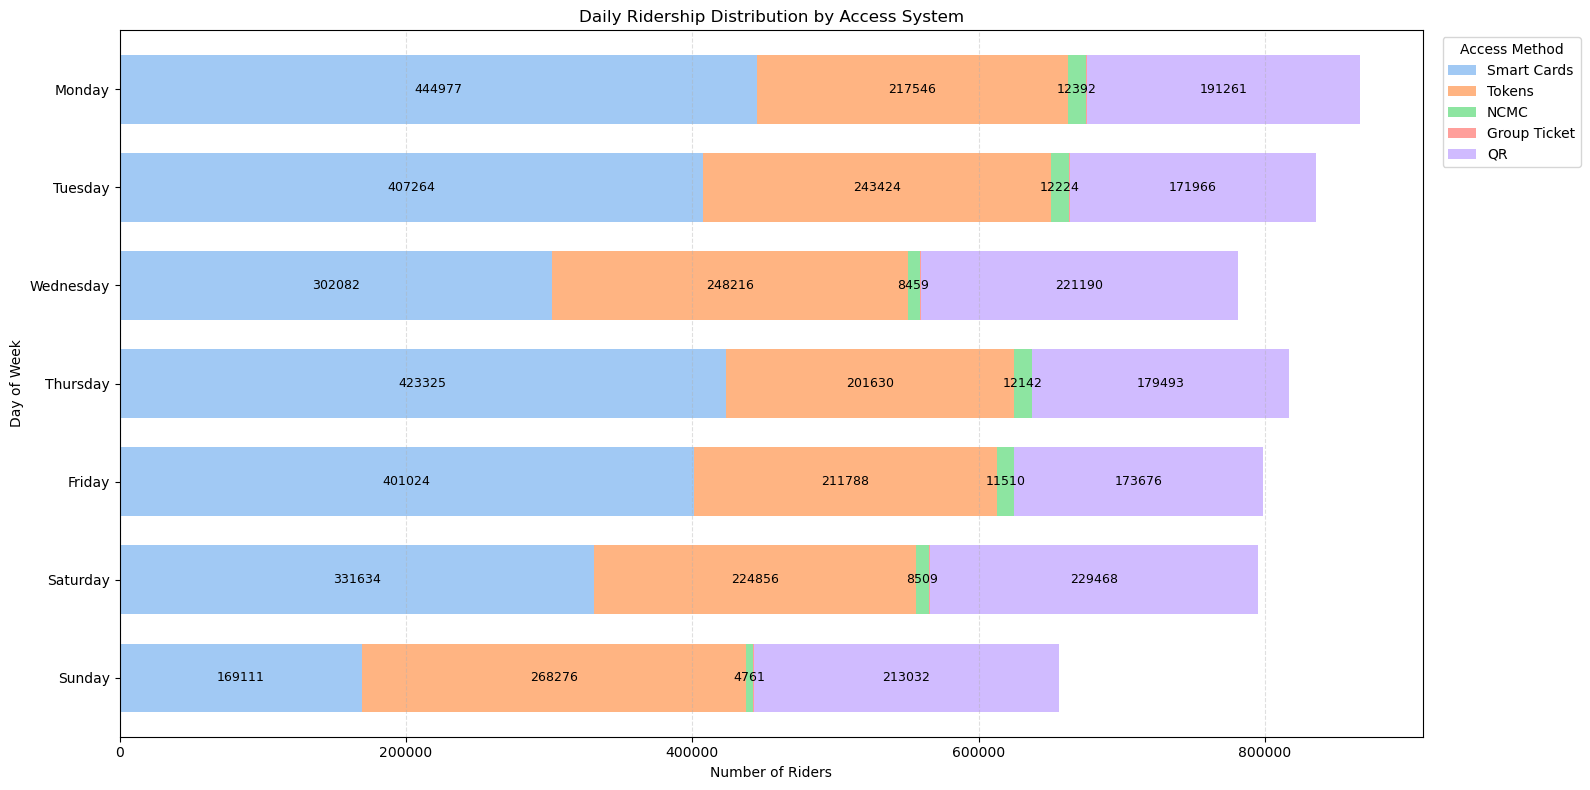

In [70]:
ax = weekly_average.plot(kind='barh', 
                         stacked=True,
                         color=sns.color_palette('pastel', 5),
                         figsize=(16, 8),
                         width=0.7,
                         rot=0)

plt.title('Daily Ridership Distribution by Access System')
plt.ylabel('Day of Week')
plt.xlabel('Number of Riders')
plt.legend(title='Access Method', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Show labels for segments based on condition
for c in ax.containers:
    labels = ['%.0f' % v if v >= 1250 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

plt.tight_layout()
plt.show()

_____

## The Metro is Getting Crowded

### Top 10 Busiest Days

In [71]:
busiest_days = df[['Record Date', 'Total Riders', 'Day of Week']].sort_values('Total Riders', ascending=False)
busiest_days.reset_index(drop=True, inplace=True)
busiest_days.index = range(1, len(busiest_days) + 1)
busiest_days.head(10)

,Record Date,Total Riders,Day of Week
1,2024-12-10,903928.0,Tuesday
2,2024-12-04,901475.0,Wednesday
3,2024-12-05,901230.0,Thursday
4,2024-12-09,895461.0,Monday
5,2024-12-13,890143.0,Friday
6,2024-11-19,889113.0,Tuesday
7,2024-12-07,883300.0,Saturday
8,2024-12-12,883218.0,Thursday
9,2024-12-16,879557.0,Monday
10,2024-11-11,878225.0,Monday


### 👆🏼 In December 2024, NammaMetro daily ridership crossed 900,000 for the first time!

### Least Busy Days so far

In [72]:
busiest_days.tail(10)

,Record Date,Total Riders,Day of Week
52,2024-11-24,680853.0,Sunday
53,2024-12-27,677483.0,Friday
54,2024-11-10,654523.0,Sunday
55,2024-12-22,649582.0,Sunday
56,2024-10-27,637048.0,Sunday
57,2024-12-29,600289.0,Sunday
58,2024-12-01,575702.0,Sunday
59,2024-11-03,536524.0,Sunday
60,2024-11-02,480284.0,Saturday
61,2024-11-01,404342.0,Friday


### 👆🏼 NammaMetro is more popular for the weekday work commute than for getting around on the weekends 

### By Quartile

In [73]:
N = 75
Nth_quantile = busiest_days['Total Riders'].quantile(N/100)
busiest_days[busiest_days['Total Riders'] > Nth_quantile].value_counts('Day of Week')

Day of Week
Monday       4
Thursday     3
Wednesday    3
Friday       2
Tuesday      2
Saturday     1
Name: count, dtype: int64

### 👆🏼 Manic Mondays

Mondays are most frequent in the 4th Quartile whereas

### 👇🏼 Weekends begin on Friday

Traffic eases down starting Friday

In [74]:
N = 25
Nth_quantile = busiest_days['Total Riders'].quantile(N/100)
busiest_days[busiest_days['Total Riders'] < Nth_quantile].value_counts('Day of Week')

Day of Week
Sunday      8
Saturday    3
Friday      2
Thursday    1
Tuesday     1
Name: count, dtype: int64

### Ridership by Month

In [75]:
df[(df['Record Date'] >= '2024-11-01') & (df['Record Date'] <= '2024-12-31')].groupby(df['Record Date'].dt.to_period('M'))['Total Riders'].sum().astype('Int64')

Record Date
2024-11    19717435
2024-12    22363482
Freq: M, Name: Total Riders, dtype: Int64

Official reported monthly ridership:

- November 2024: 2,36,13,895